# Autoencoders

In [1]:
from const import *
from IPython.display import display, Math, Image

## Structure of the Autoencoders

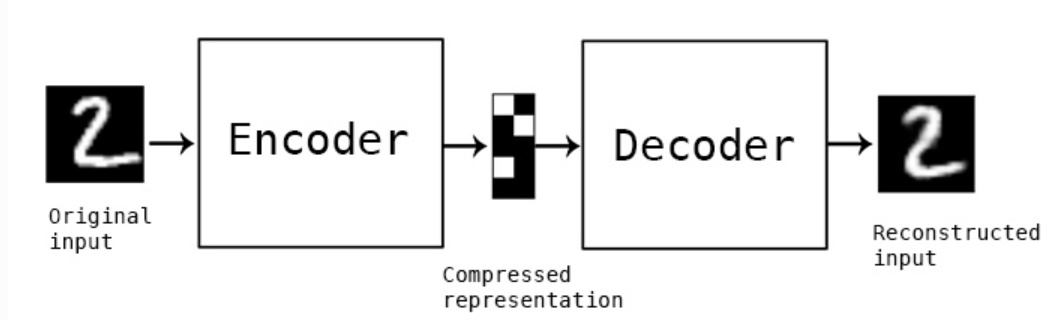

<IPython.core.display.Math object>

In [2]:
display(Image(filename=autoencoder_image, width=600, height=600))
display(Math(autoencoder_formulas))

### Autoencoders hyperparameters are:

- **number of layers**  for the *Encoder* and *Decoder* neural networks;
- **number of nodes** for each of these layers;
- **loss function** to use for the optimization process;
- **size of the latent space**, the smaller the size, the higher the compression and viceversa.

### Types of Autoencoders:
- **Undercomplete Autoencoder**, where the size of the latent space is smaller than the size of the input;
- **Sparse Autoencoder**, where the number of nodes in the hidden layer is smaller than the number of nodes in the input layer;
- **Contractive Autoencoder**, where the loss function is augmented with a term that penalizes the derivative of the hidden layer with respect to the input;
- **Denoising Autoencoder**, where the input is corrupted by adding noise to it;
- **Convolutional Autoencoder**, where the encoder and decoder are convolutional neural networks;
- **Variational Autoencoder**, where the latent space is a probability distribution.

## Python Tutorial

     ---------------------------------------- 82.7/82.7 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
     ------------------------------------- 162.8/162.8 KB 10.2 MB/s eta 0:00:00
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105812 sha256=a73cc03fdfc23306a79ea262b5b8830d5e0d9f620c73637f727b9c5612bdab85
  Stored in directory: c:\users\andre\appdata\local\pip\cache\wheels\9f\af\22\bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.5.18.1
    Uninstalling certifi-2022.5.18.1:
      Successfully uninstalled certifi-2022.5.18.1


You should consider upgrading via the 'C:\Users\andre\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
